# Tutorial 8 - seq2seq & Active Learning

**Semester:** Fall 2020

**Adapted by:** [Kevin Dick](https://kevindick.ai/)

**Part I adapted from:** [seq2seq Tutorial](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py) originally from this [Keras Blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

**Part II adapted from:** Clay Woolam <clay@woolam.org> under a BSD License.

---

## PART 1(a): seq2seq LSTM Model

The cannonical example of a `seq2seq` learning task is **language translation**. A seqence represening a sentence in one language is encoded into a latent space (an embedded representation) and then decoded into another language.

**Neither fixed input/output length:** The input of characters of variable length and from a given alphabet needs to somehow be converted into an out also variable in length and possibly from an altogether different alphabet.

`seq2seq` models generally require **massive amounts** of data to effectively learn their task and this tutorial focuses on a unique example that allows the generation of large amounts of data:

### Method: 

We will generate thousands of **string**-representation of math questions (e.g. `"39+3"`) and their target **string**-representation answer (e.g. `"42"`). These will be vectorized and used to train an LSTM model that will learn the "translation" task of converting a query string from "question-language" into a target string in "answer-language"!


In [ ]:
# -*- coding: utf-8 -*-
'''
# An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits reversed:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits reversed:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits reversed:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits reversed:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''  # noqa
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [ ]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)
questions = []
expected = []
seen = set()

In [ ]:
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

print('Total addition questions:', len(questions))

In [ ]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

In [ ]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]
print('Training Data:')
print(x_train.shape)
print(y_train.shape)
print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
352/352 [==

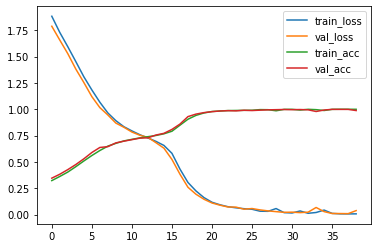

In [ ]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [ ]:
# Store val_loss and accuracy for visulization and early stopping
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
patience=3
min_delta=0.001
val_loss_increase=0

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    train_history=model.fit(x_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=1,
                            validation_data=(x_val, y_val))
    # Terminate the iteration if val_loss stop's decresing
    train_loss.append(train_history.history['loss'][0])
    val_loss.append(train_history.history['val_loss'][0])
    train_acc.append(train_history.history['accuracy'][0])
    val_acc.append(train_history.history['val_accuracy'][0])
    if iteration>1 :
        if val_loss[iteration-2]-val_loss[iteration-1]<min_delta:
            val_loss_increase+=1
            print("Validation_loss increased")
            if val_loss_increase>=patience: 
                print("Stoping because validation loss did not decrease")
                break
        else : 
            print("Validation_loss decreased")
            val_loss_increase=0

    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_loss', 'val_loss','train_acc','val_acc'])
plt.show() 

## Part I(b) - Subtraction and Variable Length Input

This second implementation demonstrates **subtraction** and permits **variable length** inputs.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense
import numpy as np

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

__training_size = 50000
__digits = 5
__hidden_size = 128
__batch_size = 128
maxlen = __digits + 1 + __digits

# All the numbers, plus sign and space for padding.
chars = '0123456789+- '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < __training_size:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, __digits + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(a - b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (__digits + 1 - len(ans))

    questions.append(query)
    expected.append(ans)
    
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), __digits + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, __digits + 1)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

model = Sequential()
model.add(LSTM(__hidden_size, input_shape=(maxlen, len(chars))))
model.add(RepeatVector(__digits + 1))
model.add(LSTM(__hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

for iteration in range(1, 50):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=__batch_size,
              epochs=1,
              validation_data=(x_val, y_val))

    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)

Generating data...
Total addition questions: 50000
Vectorization...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72704     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
352/352 [==============================] - 3s 7ms/step - loss: 1.8129 - accuracy: 0.3649 - val_loss: 1.6118 - val_ac

## Part I (c)- Bonus: the Douglas R. Hofstadter `pq`-system as a `seq2seq` task

For those familiar with Dr. Douglas Hofstadter's masterpiece [**(GEB) Gödel, Escher, Bach: and Eternal Golden Braid**](https://www.physixfan.com/wp-content/files/GEBen.pdf), the `pq`-system that Hofstader leverages heavily throughout the book can also be leveraged as an example of a `seq2seq` task.

More formally, the `pq`-system has only three disting symbols: `p`, `q`, and `-` and these are used in combination to generate statements/theorems for this system such as:

`--p---q-----`

`-p-q--`

`----------p-q-----------`

When you look at these example strings, can you *discern a meaning* for what the symbols `p`, `q`, and `-` stand for? As a human, we might try to identify a pattern within a large number of these statements and hope to deduce a pattern that allows us to generate new and valid statements within this system. 

### Excerpt from GEB (Chapter II: Isomorphisms Induce Meaning):

> Perhaps you have already thought to yourself that the `pq`-theorems are like additions. The string `--p---q-----` is a theorem because 2 plus 3 equals 5. It could even occur to you that the theorem `--p---q-----` is a statement, written in an odd notation, whose meaning is that **2 plus 3 is 5**. Is this a reasonable way to look at things? Well, I deliberately chose 'p' to remind you of 'plus',and 'q' to remind you of 'equals' . . . So, does the string `--p---q-----` actually mean "2 plus 3 equals 5"?

Aside: GEB is **strongly recommended** to those with deep interests at the intersection of *mathematics, artificial intelligence, philosophy, cognition, musical theory, and the arts.*

For the purposes of understanding the utility of `seq2seq` on solving arbitrary **string translation** tasks, this is precisely what a machine learning algorithm must do. 

**Presented with thousands of examples of valid query strings and their targets, the model learns an internal representation that allows it to correctly map the meaning of an assembly of sybmols into an alternative and valid representation.**

---

Similar to the examples above that generate example mathematical strings and have the model learn to "translate" that input string into its resulting output, we will generate pairs of strings valid in Hofstadter's `pq`-system:

**Example:** Input `x="---p--"` with target `y="q-----"`





In [62]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense
import numpy as np

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

training_size = 50000
digits = 1000 # A "digit" here is a dash and we need to allow up to 1000 in length
hidden_size = 128
batch_size = 128
maxlen = digits + 1 + digits

# The dash for numbers, p for plus sign, q for equals and space for padding.
chars = '-pq '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < training_size:
    f = lambda: ''.join('-' for i in range(np.random.randint(1, digits + 1)))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}p{}'.format(a, b)
    query = q + ' ' * (maxlen - len(q))
    ans = 'q' + '-' * (len(a) + len(b))
    # Answers can be of maximum size DIGITS * 2.
    ans += ' ' * (maxlen - len(ans))

    questions.append(query)
    expected.append(ans)
    
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [63]:
print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
print('Vectorizing questions...')
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
print('Vectorising answers...')
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, maxlen)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

print('Splitting into train and validation sets...')
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print(f'Size train: {len(x_train)}\tSize val: {len(x_val)}\nFirst train input: {x_train[0]}\nFirst train answer: {y_train[0]}')

Vectorization...
Vectorizing questions...
Vectorising answers...
Splitting into train and validation sets...
Size train: 45000	Size val: 5000
First train input: [[False  True False False]
 [False  True False False]
 [False  True False False]
 ...
 [ True False False False]
 [ True False False False]
 [ True False False False]]
First train answer: [[False False False  True]
 [False  True False False]
 [False  True False False]
 ...
 [ True False False False]
 [ True False False False]
 [ True False False False]]


In [67]:
model = Sequential()
model.add(LSTM(hidden_size, input_shape=(maxlen, len(chars))))
model.add(RepeatVector(maxlen))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

for iteration in range(1, 50):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              validation_data=(x_val, y_val))

    # Show only three examples per iteration
    for i in range(3):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q)
        print('T', correct)
        if correct == guess:
            print('☑')
        else:
            print('☒')
        print(guess)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               68096     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 2001, 128)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 2001, 128)         131584    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2001, 4)           516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
352/352 [==============================] - 98s 278ms/step - loss: 0.5315 - accuracy: 0.6984 - val_loss: 0.3655 - val_accuracy: 0.8334
Q ----------------------------------------------

## Part II - Active Learning

When only a **limited amount of labelled data** are available to train a model, we train a model using the available labelled data and apply the model to a typically larger set of unlabelled instances. Among the predicted set of points, we **identify a subse**t for which the model is **least confident** in and then **query an oracle and obtain labels** for those ponits. 

We then **retrain the model** and u**pdate the decision boundary**. We then repeeat: identify the next set of uncertain points, query oracle, and retrain  until a **defined completion criteria**.

---

Here, we demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 40 labeled points.
Of the unlabelled points, we pick the 5 that the model is least confident in and obtain labels for them.

Next, we train with 45 labeled points (original 40 + 5 new ones). We repeat this process **four times** to have a model trained with 60 labeled examples. 

Note: you can increase this to label more than 60 by changing `max_iterations`. Labeling more than 60 can be useful to get a sense for the speed of convergence of this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset and shuffle the order of data
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

# Grab a subset of the data (330 random labelled samples)
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40     # Start with 40 labelled points
max_iterations = 5        # Will have 5 iterations. Add 5 newly labelled points at each iteration.

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:] # Create nparray of indices between 40..329

### Begin Active Learning

We run through four iterations oof model refinement and then summarize results.


Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0  0 27  0

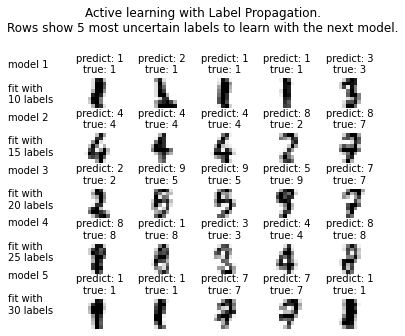

In [3]:
f = plt.figure()
for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1   # Use -1 label to indicate to label propagation algorithm that these samples are unlabelled

    # Train a label propagation model. This is based on "transductive learning"
    # K-NN is an example of transductive learning. Label unlabelled samples,
    # given labels of few known training samples...
    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    # Use trained model to predict labels for unlabelled samples
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    # Compute the confusion matrix and print performance at each iteration
    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    # Here, entropy is used a measure of uncertainty
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        # Pretty printing
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remove from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()

**Q:** Are the **most uncertain** samples those *closest-to*, *furthest-from*, or *neither* from the **decision boundary**?

# Takeaway Messages
* The cannonical example of a `seq2seq` learning task is **language translation**: a seqence represening a sentence in one language is encoded into a latent space (an embedded representation) and then decoded into another language.
* In translation, the **input of characters of variable length** and from a **given alphabet** needs to be converted into an **output also variable in length** and possibly from an altogether **different alphabet**.
* `seq2seq` models generally require **massive amounts** of data to effectively learn their task.
* Active learniing is useful when only a **limited amount of labelled data** are available to train a model.
* An Active Learning model is trained using the following steps:
1.   train model on **available labelled data**
2.   **apply model** to **unlabelled** samples
3.   pick a set of **least certain samples**, 
4.   **query an oracle** to obtain **labels**
5.   **retrain** the model
6.   (**Repeat** until a **stop criterion**)